In [293]:
import time
import pyproj
from concurrent.futures import as_completed
from pathlib import Path
from pprint import pprint, pformat
from textwrap import indent

import geofeather
import geopandas as gpd
import matplotlib as mpl
import numpy as np
import osm2geojson
import pandas as pd
import requests
from matplotlib import pyplot as plt
from pandas import core as pdcore
from pyproj.enums import TransformDirection
from requests_futures.sessions import FuturesSession
from shapely import Polygon, Point, MultiPolygon, LineString
from shapely.ops import polylabel, transform
from shapely.validation import explain_validity
from typing import cast

In [294]:
# TODO

#  - Add to version control
#  - Instead using "areas to avoid" in the initial exclusion step, exclude them when checking candidates
#  - Check why places like 60.140580 24.668884 are given as suggestions even though they should be already excluded (in this case, "landuse:residential")

In [295]:
union_query_template = """[out:json][timeout:25];
(
{union_members}
);
out body;
>;
out skel qt;
"""

not_working_well_union_query_template = """[out:json][timeout:25];
(
{union_members}
);
(._;>;);
convert item ::=::,::geom=geom(),_osm_type=type();
out skel qt;
"""

everything_query_template = """[out:json][timeout:25];
(
  way({bbox});
  relation({bbox});
);
out body;
>;
out skel qt;
"""

In [296]:
def key_val_to_tag_string(key: str, value: str | None) -> str:
    if value is None or value == "":
        return f'"{key}"'
    else:
        return f'"{key}"="{value}"'


class OSMTagWithMinDistance:
    """OSM tag with a minimum distance to the launch site.
    Distance is in meters.
    """

    def __init__(self, key, value, distance: int):
        self.key = key
        self.value = value
        self.distance = distance
        if not isinstance(self.key, str):
            raise TypeError(f"Key must be a string, not '{type(self.key)}'")

    def as_dict(self):
        return {
            "key": self.key,
            "value": self.value,
            "distance": self.distance,
        }

    def __repr__(self):
        return f"OSMTagKey({self.key}, {self.value}, {self.distance})"

    def __str__(self) -> str:
        return key_val_to_tag_string(self.key, self.value)


tall_things = [
    OSMTagWithMinDistance("power", "catenary_mast", 20),
    OSMTagWithMinDistance("power", "connection", 20),
    OSMTagWithMinDistance("power", "line", 50),
    OSMTagWithMinDistance("power", "minor_line", 25),
    OSMTagWithMinDistance("power", "pole", 25),
    OSMTagWithMinDistance("power", "portal", 35),
    OSMTagWithMinDistance("power", "substation", 10),
    OSMTagWithMinDistance("power", "terminal", 35),
    OSMTagWithMinDistance("power", "tower", 50),
    OSMTagWithMinDistance("power:generator:source", "wind", 150),
    OSMTagWithMinDistance("natural", "cliff", 25),
    OSMTagWithMinDistance("natural", "coastline", 10),
    OSMTagWithMinDistance("natural", "wood", 25),
    OSMTagWithMinDistance("landuse", "forest", 25),
    OSMTagWithMinDistance("landuse", "residential", 10),
    OSMTagWithMinDistance("landcover", "trees", 25),
]

bad_area_for_launch = [
    OSMTagWithMinDistance("natural", "water", 20),
    OSMTagWithMinDistance("natural", "wetland", 10),
    OSMTagWithMinDistance("meadow", "pasture", 10),
    OSMTagWithMinDistance("place", "islet", 5),
    OSMTagWithMinDistance("place", "island", 5),
    OSMTagWithMinDistance("highway", "motorway", 20),
    OSMTagWithMinDistance("highway", "secondary", 20),
    OSMTagWithMinDistance("highway", "tertiary", 15),
    OSMTagWithMinDistance("highway", "cycleway", 10),
    OSMTagWithMinDistance("tourism", "hotel", 5),
    OSMTagWithMinDistance("leisure", "golf_course", 5),
    OSMTagWithMinDistance("natural", "bare_rock", 5),
    OSMTagWithMinDistance("natural", "scrub", 5),
    OSMTagWithMinDistance("landuse", "commercial", 20),
    OSMTagWithMinDistance("landuse", "construction", 20),
    OSMTagWithMinDistance("landuse", "farmland", 10),    
    OSMTagWithMinDistance("landuse", "industrial", 20),
    OSMTagWithMinDistance("landuse", "military", 20),
    OSMTagWithMinDistance("landuse", "quarry", 20),
    OSMTagWithMinDistance("landuse", "landfill", 20),
    OSMTagWithMinDistance("landuse", "basin", 20),
    OSMTagWithMinDistance("landuse", "railway", 10),
    OSMTagWithMinDistance("landuse", "reservoir", 10),
    OSMTagWithMinDistance("landuse", "residential", 20),
    OSMTagWithMinDistance("landuse", "retail", 20),
    OSMTagWithMinDistance("landuse", "education", 20),
    OSMTagWithMinDistance("landuse", "institution", 10),
    OSMTagWithMinDistance("landuse", "religious", 10),
    OSMTagWithMinDistance("landuse", "cemetery", 20),
    OSMTagWithMinDistance("landuse", "orchard", 20),
    OSMTagWithMinDistance("landuse", "vineyard", 20),
    OSMTagWithMinDistance("landuse", "depot", 20),
    OSMTagWithMinDistance("landuse", "port", 30),
    OSMTagWithMinDistance("waterway", "boatyard", 20),
]

be_far_away_from = [
    OSMTagWithMinDistance("aeroway", "aerodrome", 20 * 1000),
]

keep_away_from_when_launching = tall_things + bad_area_for_launch + be_far_away_from
# pprint(keep_away_from_when_launching)

In [297]:
def osm_tags_to_query(tags: list[OSMTagWithMinDistance]) -> str:
    feature_types = ["node", "way", "relation"]
    simple_query_template = "{feature_type}[{tag}]({bbox});"
    union_members = []
    for feature_type in feature_types:
        for tag in tags:
            format_map = {
                "feature_type": feature_type,
                "tag": tag,
                "bbox": "{bbox}",
            }
            simple_query = simple_query_template.format(**format_map)
            union_members.append(simple_query)
    union_members_on_lines = "\n".join(union_members)
    union_members_indented = indent(union_members_on_lines, "  ")
    prepared_query = union_query_template.format(union_members=union_members_indented)
    return prepared_query


bad_stuff_query = osm_tags_to_query(keep_away_from_when_launching)
# print(bad_stuff_query)

In [298]:
espoo_kirkkonummi_bbox = (60.05, 24.45, 60.23, 24.90)
uusimaa_bbox = (59.75, 23.75, 60.75, 25.75)
bbox_of_view_bounds = espoo_kirkkonummi_bbox

main_crs = "EPSG:4326"
middle_of_view_bounds_longitude = (
    bbox_of_view_bounds[1] + bbox_of_view_bounds[3]
) / 2
metric_crs = f"+proj=tmerc +lon_0={middle_of_view_bounds_longitude} +x_0=500000 +k=0.9996"

transform_main_to_metric = pyproj.Transformer.from_proj(
    main_crs,
    metric_crs,
)

bbox_xy = (
    bbox_of_view_bounds[1],
    bbox_of_view_bounds[0],
    bbox_of_view_bounds[3],
    bbox_of_view_bounds[2],
)
bbox_xx_yy = (
    bbox_of_view_bounds[1],
    bbox_of_view_bounds[3],
    bbox_of_view_bounds[0],
    bbox_of_view_bounds[2],
)
bbox_coords = map(str, bbox_of_view_bounds)
bbox_string = ",".join(bbox_coords)

### Create queries grouped by distance

In [299]:
distances = set([tag.distance for tag in keep_away_from_when_launching])
bad_stuff_tags_by_distance = {
    distance: [tag for tag in keep_away_from_when_launching if tag.distance == distance]
    for distance in distances
}

queries_without_bboxes = {
    distance: osm_tags_to_query(tags)
    for distance, tags in bad_stuff_tags_by_distance.items()
}


def expand_bbox(
    bbox: tuple[float, float, float, float], distance: int
) -> tuple[float, float, float, float]:
    """Expand the bbox by the distance + a bit extra to include possible bad stuff which
    affects the possible launch area from far away (large distance value).
    """
    padding_multiplier = 1.01
    padded_distance = distance * padding_multiplier
    expanded_bbox = (
        bbox[0] - padded_distance,
        bbox[1] - padded_distance,
        bbox[2] + padded_distance,
        bbox[3] + padded_distance,
    )
    return expanded_bbox


queries_with_bboxes: dict[int, str] = {}
for distance, query in queries_without_bboxes.items():
    # Expand the bbox by the distance to include possible bad stuff with a
    # large distance which should be taken into account.
    print(f"for distance: {distance}")
    # print(f"before expand_bbox: {bbox_of_view_bounds}")

    # To metric for the expand_bbox function
    bbox_of_view_metric = transform_main_to_metric.transform_bounds(*bbox_of_view_bounds)
    # print(f"bbox_of_view_metric: {bbox_of_view_metric}")

    expanded_bbox_metric = expand_bbox(bbox_of_view_metric, distance)
    # print(f"expanded_bbox_metric: {expanded_bbox_metric}")

    # Back to main crs
    expanded_bbox = transform_main_to_metric.transform_bounds(
        *expanded_bbox_metric, direction=TransformDirection.INVERSE
    )

    print(f"after expand_bbox: {expanded_bbox}")
    expanded_bbox_coords = map(str, expanded_bbox)
    expanded_bbox_string = ",".join(expanded_bbox_coords)
    query_with_bbox = query.replace("{bbox}", expanded_bbox_string)
    queries_with_bboxes[distance] = query_with_bbox

# pprint(queries_with_bboxes)

for distance: 20000
after expand_bbox: (59.867321253923315, 24.080810679436656, 60.4115629740867, 25.269189320563342)
for distance: 35
after expand_bbox: (60.049490080637405, 24.44812705142189, 60.23050812854638, 24.90187294857811)
for distance: 5
after expand_bbox: (60.04976307533923, 24.44867595757806, 60.23023606643541, 24.90132404242194)
for distance: 10
after expand_bbox: (60.049717576377084, 24.448584473848335, 60.23028141012135, 24.901415526151663)
for distance: 15
after expand_bbox: (60.049672077353, 24.448492989866754, 60.23032675380699, 24.901507010133244)
for distance: 50
after expand_bbox: (60.049353582450465, 24.447852594943736, 60.23064415959766, 24.902147405056265)
for distance: 20
after expand_bbox: (60.04962657826699, 24.44840150563332, 60.23037209749231, 24.901598494366677)
for distance: 150
after expand_bbox: (60.04844358029493, 24.446022827160558, 60.231551033201, 24.903977172839443)
for distance: 25
after expand_bbox: (60.049581079119044, 24.448310021148032, 60.230

### Send queries

In [300]:
# Send queries to Overpass API
overpass_url = "http://overpass-api.de/api/interpreter"


def response_hook(resp, *args, **kwargs):
    print(f"got response with url: {resp.url}")
    print(f"response status: {resp.status_code}")

    if resp.status_code != 200:
        # print(f"Error: {resp.text}")
        print(f"request body: {resp.request.body}")
        raise Exception("Error")

    result = osm2geojson.json2geojson(resp.text)
    resp.geojson = result


session = FuturesSession()
session.hooks["response"] = response_hook

futures = []
for distance, query in queries_with_bboxes.items():
    print(f"launching query with distance {distance}")
    future = session.post(overpass_url + f"#{distance}", data=query)
    future.distance = distance
    futures.append(future)

geojson_features = []
for future in as_completed(futures):
    resp = future.result()
    distance = future.distance
    geojson = resp.geojson
    features = geojson["features"]
    print(f"got response for distance {distance}, {len(features)} features")
    geojson_features.extend(features)

print(f"got {len(geojson_features)} features in total")

launching query with distance 20000
launching query with distance 35
launching query with distance 5
launching query with distance 10
launching query with distance 15
launching query with distance 50
launching query with distance 20
launching query with distance 150
launching query with distance 25
launching query with distance 30
got response with url: http://overpass-api.de/api/interpreter#150
response status: 200
got response with url: http://overpass-api.de/api/interpreter#35
response status: 200
got response for distance 150, 0 features
got response for distance 35, 21 features
got response with url: http://overpass-api.de/api/interpreter#15
response status: 200
got response with url: http://overpass-api.de/api/interpreter#30
response status: 200
got response for distance 30, 0 features
got response with url: http://overpass-api.de/api/interpreter#50
response status: 200
got response with url: http://overpass-api.de/api/interpreter#20000
response status: 200
got response for dista

In [301]:
tag_distance = {
    key_val_to_tag_string(tag.key, tag.value): tag.distance
    for tag in keep_away_from_when_launching
}


def split_tag_into_key_and_value(tag_string):
    """A tag is split by the last colon into key and value
    Wildcard tags of format "<key>:*" or "<key>" have value None
    """
    if ":" in tag_string:
        key, value = tag_string.rsplit(":", maxsplit=1)
        if value == "*":
            value = None
    else:
        key = tag_string
        value = None
    return key, value


# A tag is split by the last colon into key and value
# Wildcard tag: "<key>:*" or "<key>"
def tags_match(
    key1: str,
    value1: str | None,
    key2: str,
    value2: str | None,
):
    if value1 == "*":
        value1 = None
    if value2 == "*":
        value2 = None

    if not key1 or not key2:
        ValueError("key1 and key2 must be non-empty strings")

    return key1 == key2 and (value1 is None or value2 is None or value1 == value2)


def get_distance(row: pd.Series):
    distances = []
    for k, v in row["tags"].items():
        distances_for_matches = [
            osm_tag.distance
            for osm_tag in keep_away_from_when_launching
            if tags_match(k, v, osm_tag.key, osm_tag.value)
        ]
        if k == "aeroway":
            print(f"got distances for aeroway: {distances_for_matches}")
        distances.extend(distances_for_matches)
    if distances:
        return max(distances)
    else:
        raise ValueError(f"Could not find distance for {row}")

### Form GeoDataFrame, filter columns

In [302]:
gdf = gpd.GeoDataFrame.from_features(geojson_features, crs=main_crs)
gdf = cast(gpd.GeoDataFrame, gdf)
pprint(list(gdf.columns))

gdf["full_id"] = gdf["type"] + "/" + gdf["id"].astype(str)

columns_to_keep = ["geometry", "full_id", "tags"]
gdf = gdf[columns_to_keep]
gdf = cast(gpd.GeoDataFrame, gdf)

gdf.head()

['geometry', 'type', 'id', 'tags', 'nodes']


,geometry,full_id,tags
0,POINT (24.64543 60.22165),node/252167965,{'power': 'portal'}
1,POINT (24.54907 60.20455),node/313113159,{'power': 'portal'}
2,POINT (24.63085 60.21565),node/313113177,{'power': 'portal'}
3,POINT (24.63387 60.21665),node/313113178,{'power': 'portal'}
4,POINT (24.63776 60.21821),node/313113179,{'power': 'portal'}


In [303]:
gdf["full_id"].apply(lambda x: x.split("/")[0]).value_counts()

full_id
way         38507
relation      532
node          154
Name: count, dtype: int64

In [304]:
gdf = cast(gpd.GeoDataFrame, gdf)
gdf = gdf.explode()

In [305]:
# search for id in gdf
id_to_look_for = "relation/14989686"
gdf[gdf["full_id"] == id_to_look_for]

full_id                                         tags   
16060 0  relation/14989686  {'natural': 'wood', 'type': 'multipolygon'}  \
      1  relation/14989686  {'natural': 'wood', 'type': 'multipolygon'}   

                                                  geometry  
16060 0  POLYGON ((24.57394 60.17959, 24.57134 60.17924...  
      1  POLYGON ((24.56978 60.17914, 24.57266 60.17950...

In [306]:
search_for_name = "Tavasten"
gdf[gdf["tags"].apply(lambda tags: tags.get("name", None) == search_for_name)]

,,full_id,tags,geometry
39144,0,relation/14034193,"{'name': 'Tavasten', 'place': 'islet', 'type':...","POLYGON ((24.60385 60.05578, 24.60384 60.05575..."


### Remove duplicates

In [307]:
# remove duplicates
print(f"len(gdf): {len(gdf)}")
gdf = gdf.drop_duplicates(subset=["full_id"])
print(f"len(gdf): {len(gdf)}")

len(gdf): 39287
len(gdf): 35661


In [308]:
gdf.geometry.type.value_counts()

Polygon       19187
LineString    16320
Point           154
Name: count, dtype: int64

In [309]:
gdf_before_polygonize = gdf.copy()
linestrings_before_polygonize = gdf[gdf.apply(lambda row: row.geometry.type == "LineString", axis=1)].copy()

### Linestrings into polygons

In [310]:
def is_linestring_proper_polygon(lstring):
    """Check if a linestring is a proper polygon
    (i.e. the first and last coordinates are the same)
    """
    return lstring.coords[0] == lstring.coords[-1]

def polygonize(geometry):
    """Get a Polygon from a LineString
    If geometry is not a LineString or is not a proper polygon, return the original geometry
    """
    if (isinstance(geometry, LineString)
        and is_linestring_proper_polygon(geometry)):
        return Polygon(geometry)
    else:
        return geometry
    

In [311]:
gdf.geometry = gdf.geometry.apply(polygonize)

In [312]:
linestrings_after_polygonize = gdf[gdf.apply(lambda row: row.geometry.type == "LineString", axis=1)].copy()
not_linestrings_anymore = linestrings_before_polygonize - linestrings_after_polygonize

In [313]:
not_linestrings_anymore.head()

16  0    LINESTRING Z EMPTY
17  0    LINESTRING Z EMPTY
18  0    LINESTRING Z EMPTY
19  0    LINESTRING Z EMPTY
20  0    LINESTRING Z EMPTY
dtype: geometry

In [314]:
gdf.geometry.type.value_counts()

Polygon       19881
LineString    15626
Point           154
Name: count, dtype: int64

<Axes: >

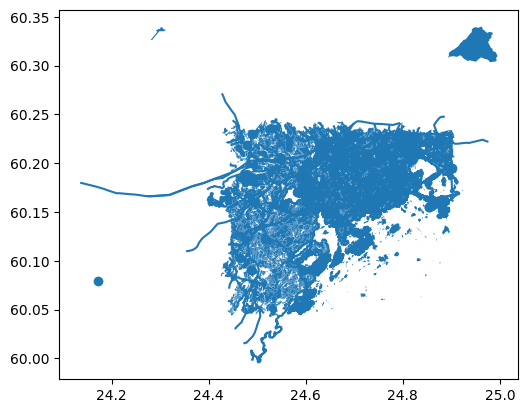

In [315]:
# Plot before unification
gdf.plot()

### Unification tools

In [316]:
from copy import deepcopy
from dataclasses import dataclass
from shapely.geometry.base import BaseGeometry
import shapely


class Glob:
    def __init__(self, geometry: BaseGeometry | list[BaseGeometry], ids: list[str], tags: dict[str, str]):
        self.geometry: list[BaseGeometry] = geometry if isinstance(geometry, list) else [geometry]
        self.ids: list[str] = ids
        self.tags: dict[str, str] = tags
    
    def merge_with(self, other: "Glob"):
        self.geometry.extend(other.geometry)
        self.ids.extend(other.ids)
        self.tags = {**self.tags, **other.tags}

    def to_dict_with_unioned_geometry(self):
        return {
            "geometry": shapely.unary_union(self.geometry),
            "ids": self.ids,
            "tags": self.tags,
        }


# geometry by full_id
def get_geometry_by_full_id(geodf: gpd.GeoDataFrame, full_id: str):
    geometries = geodf[geodf["full_id"] == full_id].geometry
    if len(geometries) > 1:
        raise ValueError(f"More than one geometry for full_id {full_id}")
    return geometries.iloc[0]

### Unify what can be unified

In [317]:
sjoin_start_time = time.perf_counter()
gdf_sjoined = gdf.sjoin(gdf, how="left", op="overlaps")
print(f"sjoin time: {time.perf_counter() - sjoin_start_time}")

gdf_sjoin_overlapping_ids = set(list(gdf_sjoined["full_id_left"]) + list(gdf_sjoined["full_id_right"]))
print(f"sjoined ids: {gdf_sjoin_overlapping_ids}")

geometry_dict_creation_start_time = time.perf_counter()
geometry_by_full_id = {
    row.full_id: row.geometry for index_val, row in gdf.iterrows()
}
print(f"geometry_dict_creation time: {time.perf_counter() - geometry_dict_creation_start_time}")

sjoin time: 16.703056676953565
sjoined ids: {'way/849471753', 'way/467941166', 'way/521056704', 'way/744667788', 'way/24472024', 'way/1175554973', 'way/934941383', 'way/877076300', 'way/478287426', 'way/155967397', 'way/158020649', 'way/23733367', 'way/29341891', 'way/483195993', 'way/673453968', 'way/27170041', 'way/713850466', 'way/309645755', 'way/34174568', 'way/235965752', 'way/793060628', 'way/1158135926', 'way/747289681', 'way/875513056', 'way/8135970', 'way/29156427', 'way/76737122', 'way/26991648', 'way/832293218', 'way/140771564', 'way/754296657', 'way/4407965', 'way/914378691', 'way/94747723', 'way/478049494', 'way/740291090', 'way/1149648027', 'way/800174440', 'way/27533150', 'way/880572736', 'way/907071563', 'way/590448433', 'way/140233245', 'way/753433789', 'way/241933877', 'way/151943354', 'way/760769409', 'way/1128259654', 'way/799189302', 'way/98102535', 'way/1113256921', 'way/46968387', 'way/34443794', 'way/23692206', 'way/33922706', 'way/28554715', 'way/515749352', '

In [318]:
# Do sjoin to find what is intersecting, then do manual merge of those geometries and tags
do_report = False
reporting_interval = len(gdf) // 25

# "globs", i.e. polygons which intersect with each other
# each glob is a row
# each id of a feature has a glob it belongs to
id_to_glob: dict[str, Glob] = {}
merge_times_s = []
glob_to_merge_creation_times_s = []
iteration_times_s = []
id_update_times_s = []
creating_new_glob_times_s = []
getting_geometry_by_full_id_from_dict_times_s = []
row_namedtuples_creation_start_time = time.perf_counter()
row_namedtuples = gdf_sjoined.itertuples()
print(f"row_namedtuples_creation time: {time.perf_counter() - row_namedtuples_creation_start_time}")
for i, row_namedtuple in enumerate(gdf_sjoined.itertuples()):
    iteration_start_time = time.perf_counter()
    if do_report and i != 0 and i % reporting_interval == 0:
        print(f"{i} / {len(gdf_sjoined)}")
        print(f"iteration average: {np.mean(iteration_times_s) * 1e6:.1f} us, max: {np.max(iteration_times_s) * 1e6:.1f} us, min: {np.min(iteration_times_s) * 1e6:.1f} us, std: {np.std(iteration_times_s) * 1e6:.1f} us")
        print(f"glob to merge creation average : {np.mean(glob_to_merge_creation_times_s) * 1e6:.1f} us, {np.mean(glob_to_merge_creation_times_s) / np.mean(iteration_times_s) * 100:.1f} % of total, max: {np.max(glob_to_merge_creation_times_s) * 1e6:.1f} us, min: {np.min(glob_to_merge_creation_times_s) * 1e6:.1f} us, std: {np.std(glob_to_merge_creation_times_s) * 1e6:.1f} us")
        print(f"merge average : {np.mean(merge_times_s) * 1e6:.1f} us, {np.mean(merge_times_s) / np.mean(iteration_times_s) * 100:.1f} % of total, max: {np.max(merge_times_s) * 1e6:.1f} us, min: {np.min(merge_times_s) * 1e6:.1f} us, std: {np.std(merge_times_s) * 1e6:.1f} us")
        print(f"id update average: {np.mean(id_update_times_s) * 1e6:.1f} us, % time spent updating id: {np.mean(id_update_times_s) / np.mean(iteration_times_s) * 100:.1f} % of total, max: {np.max(id_update_times_s) * 1e6:.1f} us, min: {np.min(id_update_times_s) * 1e6:.1f} us, std: {np.std(id_update_times_s) * 1e6:.1f} us")
        print(f"creating new glob average: {np.mean(creating_new_glob_times_s) * 1e6:.1f} us, {np.mean(creating_new_glob_times_s) / np.mean(iteration_times_s) * 100:.1f} % of total, max: {np.max(creating_new_glob_times_s) * 1e6:.1f} us, min: {np.min(creating_new_glob_times_s) * 1e6:.1f} us, std: {np.std(creating_new_glob_times_s) * 1e6:.1f} us")
        print(f"getting geometry by full id from dict average : {np.mean(getting_geometry_by_full_id_from_dict_times_s) * 1e6:.1f} us, {np.mean(getting_geometry_by_full_id_from_dict_times_s) / np.mean(iteration_times_s) * 100:.1f} % of total, max: {np.max(getting_geometry_by_full_id_from_dict_times_s) * 1e6:.1f} us, min: {np.min(getting_geometry_by_full_id_from_dict_times_s) * 1e6:.1f} us, std: {np.std(getting_geometry_by_full_id_from_dict_times_s) * 1e6:.1f} us")
    id_left = row_namedtuple.full_id_left
    id_right = row_namedtuple.full_id_right
    if id_left == id_right:
        # skip self-intersections
        continue
    if id_left in id_to_glob and not id_right in id_to_glob:
        # merge right into left
        id_of_existing_glob = id_left
        id_to_merge = id_right
        tags_to_merge = row_namedtuple.tags_right
    elif id_right in id_to_glob and not id_left in id_to_glob:
        # merge left into right
        id_of_existing_glob = id_right
        id_to_merge = id_left
        tags_to_merge = row_namedtuple.tags_left
    elif id_left in id_to_glob and id_right in id_to_glob:
        # both are in a glob already, so skip
        continue
    else:
        # neither are in a glob, so create a new one
        creating_new_glob_start = time.perf_counter()
        getting_geometry_by_full_id_from_dict_start = time.perf_counter()
        new_glob_geometry = geometry_by_full_id[id_left]
        getting_geometry_by_full_id_from_dict_times_s.append(time.perf_counter() - getting_geometry_by_full_id_from_dict_start)
        new_glob = Glob(
            new_glob_geometry,
            [id_left],
            row_namedtuple.tags_left,
        )
        creating_new_glob_times_s.append(time.perf_counter() - creating_new_glob_start)
        id_to_glob[id_left] = new_glob
        if id_right is np.nan:
            # left doesn't intersect with anything, so skip merging
            continue
        id_of_existing_glob = id_left
        id_to_merge = id_right
        tags_to_merge = row_namedtuple.tags_right
    existing_glob = id_to_glob[id_of_existing_glob]
    glob_to_merge_creation_start = time.perf_counter()
    geometry_to_merge = geometry_by_full_id[id_to_merge]
    glob_to_merge = Glob(
        geometry_to_merge,
        [id_to_merge],
        tags_to_merge,
    )
    glob_to_merge_creation_times_s.append(time.perf_counter() - glob_to_merge_creation_start)
    merge_start = time.perf_counter()
    existing_glob.merge_with(glob_to_merge)
    merge_times_s.append(time.perf_counter() - merge_start)
    merged_glob = existing_glob
    # update id_to_glob
    id_update_start = time.perf_counter()
    for id_to_update in merged_glob.ids:
        id_to_glob[id_to_update] = merged_glob
    id_update_times_s.append(time.perf_counter() - id_update_start)
    iteration_times_s.append(time.perf_counter() - iteration_start_time)


row_namedtuples_creation time: 0.026916978997178376


In [319]:
# Find features tagges with "aeroway"

gdf.apply(get_distance, axis=1).value_counts()

got distances for aeroway: [20000]
got distances for aeroway: [20000]
got distances for aeroway: [20000]


10       12567
25        7314
5         7000
20        6680
15        2008
50          68
35          21
20000        3
Name: count, dtype: int64

In [320]:
globs = set(id_to_glob.values())

In [321]:
print(f"count of polys before merging: {len(gdf)}")
print(f"count of polys after merging: {len(globs)}")

count of polys before merging: 35661
count of polys after merging: 33052


### Reconsitute dataframe

In [322]:
glob_records = (glob.to_dict_with_unioned_geometry() for glob in globs)
df_from_sjoined = pd.DataFrame.from_records(glob_records)
# Add back in the features that didn't overlap with anything
gdf_did_not_overlap = gdf[~gdf.full_id.isin(gdf_sjoin_overlapping_ids)].drop(columns=["full_id"])
concatenated = pd.concat([gdf_did_not_overlap, df_from_sjoined], ignore_index=True)
gdf = gpd.GeoDataFrame(concatenated, geometry="geometry", crs=main_crs)

In [323]:
gdf = gdf.explode()

In [324]:
gdf.head()

,,tags,ids,geometry
0,0,"{'landuse': 'forest', 'leaf_type': 'broadleaved'}",[way/1132753386],"POLYGON ((24.88659 60.16356, 24.88665 60.16354..."
1,0,"{'bicycle': 'use_sidepath', 'bridge': 'yes', '...",[way/503811378],"LINESTRING (24.76660 60.16878, 24.76629 60.16906)"
2,0,"{'bicycle': 'use_sidepath', 'highway': 'second...",[way/493448685],"LINESTRING (24.68230 60.22284, 24.68291 60.222..."
3,0,{'landuse': 'forest'},[way/683908363],"POLYGON ((24.58805 60.21993, 24.58867 60.22000..."
4,0,{'landuse': 'forest'},[way/1132757795],"POLYGON ((24.88748 60.15028, 24.88751 60.15025..."


### Fix geometry

In [325]:
gdf.geometry = gdf.make_valid()

In [326]:
gdf["geometry"].apply(explain_validity).str.split("[").str[0].value_counts()

geometry
Valid Geometry    33068
Name: count, dtype: int64

### Simplify

In [327]:
gdf = gdf.to_crs(metric_crs)
gdf = cast(gpd.GeoDataFrame, gdf)

In [328]:
simplification_tolerance_meters = 10
gdf.geometry = gdf.simplify(simplification_tolerance_meters).to_crs(main_crs)

In [329]:
def count_geom_vertices(geom):
    count = 0
    if hasattr(geom, 'geoms'):
        count += sum(count_geom_vertices(part) for part in geom.geoms)
    else:
        if hasattr(geom, 'exterior'):
            count += len(geom.exterior.coords)
        if hasattr(geom, 'interiors'):
            count += sum(len(interior.coords) for interior in geom.interiors)
    return count
    
counts = gdf.geometry.apply(count_geom_vertices)
total_vertices = counts.sum()
print(f"total vertices: {total_vertices}")


total vertices: 166713


### Buffer and find suitable areas (not yet necessarily on land)

In [330]:
%%script false --no-raise-error

distance_finding_start = time.perf_counter()
gdf["distance"] = gdf.apply(get_distance, axis=1)
print(f"distance finding took {time.perf_counter() - distance_finding_start:.1f} s")
# reproject to meters for adding buffer
gdf_buffering = gdf.to_crs(metric_crs)
gdf_buffering = cast(gpd.GeoDataFrame, gdf_buffering)
# Geometry fix
geometry_fix_start = time.perf_counter()
gdf_buffering.geometry = gdf_buffering.geometry.buffer(0.01)
print(f"geometry fix took {time.perf_counter() - geometry_fix_start:.1f} s")

buffering_start = time.perf_counter()
gdf_buffered = gdf_buffering.buffer(gdf_buffering["distance"])
gdf_buffered = cast(gpd.GeoSeries, gdf_buffered)
gdf_buffered = gdf_buffered.to_crs(main_crs)
print(f"buffering took {time.perf_counter() - buffering_start:.1f} s")

difference_start = time.perf_counter()
bbox_polygon_xy = Polygon.from_bounds(*bbox_xy)
possible_launch_area_from_difference = bbox_polygon_xy.difference(
    gdf_buffered.unary_union
)
print(f"difference took {time.perf_counter() - difference_start:.1f} s")

In [331]:
from collections import defaultdict
from multiprocessing import Pool

# With multiprocessing

def distance_buffering(distance: float, to_buffer: gpd.GeoDataFrame) -> gpd.GeoSeries:
    """It is assumed that the input is in metric crs
    """
    simplify_tolerance_meters = 10
    # Make sure all distances are the same
    if not np.isclose(to_buffer["distance"], distance, rtol=0.01, atol=0.1).all():
        raise ValueError("All distances must be the same")
    gdf_buffered = to_buffer.buffer(distance)
    gdf_buffered = cast(gpd.GeoSeries, gdf_buffered)
    gdf_buffered = gdf_buffered.simplify(simplify_tolerance_meters)
    return gdf_buffered

def distance_buffering_star(args):
    return distance_buffering(*args)

def split_given_size(a, size):
    return np.split(a, np.arange(size,len(a),size))


distance_finding_start = time.perf_counter()
gdf["distance"] = gdf.apply(get_distance, axis=1)
print(gdf["distance"].value_counts())
print(f"distance finding took {time.perf_counter() - distance_finding_start:.1f} s")
# reproject to meters for adding buffer
gdf_buffering = gdf.to_crs(metric_crs)
gdf_buffering = cast(gpd.GeoDataFrame, gdf_buffering)
# Geometry fix

buffering_start = time.perf_counter()
grouped_by_distance = [(distance, rows) for distance, rows in gdf_buffering.groupby("distance")]
lengths = {distance: len(rows) for distance, rows in grouped_by_distance}
print("lengths", pformat(lengths))
grouped_by_distance_and_split = []
for distance, rows in grouped_by_distance:
    partition_max_size = 50
    rows_split = split_given_size(rows, partition_max_size)
    grouped_by_distance_and_split.extend([(distance, rows) for rows in rows_split])
print("length of grouped_by_distance_and_split", len(grouped_by_distance_and_split))
# print([type(g) for g in grouped_by_distance])
multiprocessing_start = time.perf_counter()
with Pool() as pool:
    gdf_buffered_list = pool.starmap(distance_buffering, grouped_by_distance_and_split)
print(f"multiprocessing took {time.perf_counter() - multiprocessing_start:.1f} s")
concat_start = time.perf_counter()
gdf_buffered = gpd.GeoSeries( pd.concat(gdf_buffered_list), crs=metric_crs )
print(f"concat took {time.perf_counter() - concat_start:.1f} s")
gdf_buffered = gdf_buffered.to_crs(main_crs)
print(f"buffering took {time.perf_counter() - buffering_start:.1f} s")

difference_start = time.perf_counter()
bbox_polygon_xy = Polygon.from_bounds(*bbox_xy)
possible_launch_area_from_difference = bbox_polygon_xy.difference(
    gdf_buffered.unary_union
)
print(f"difference took {time.perf_counter() - difference_start:.1f} s")

got distances for aeroway: [20000]
got distances for aeroway: [20000]
got distances for aeroway: [20000]
distance
10       12348
25        6466
20        6140
5         6014
15        2008
50          68
35          21
20000        3
Name: count, dtype: int64
distance finding took 0.8 s
lengths {5: 6014, 10: 12348, 15: 2008, 20: 6140, 25: 6466, 35: 21, 50: 68, 20000: 3}
length of grouped_by_distance_and_split 666
multiprocessing took 2.3 s
concat took 0.1 s
buffering took 4.3 s
difference took 3.5 s


In [332]:
total_vertices = count_geom_vertices(possible_launch_area_from_difference)
print(f"total vertices: {total_vertices}")

total vertices: 21493


<Axes: >

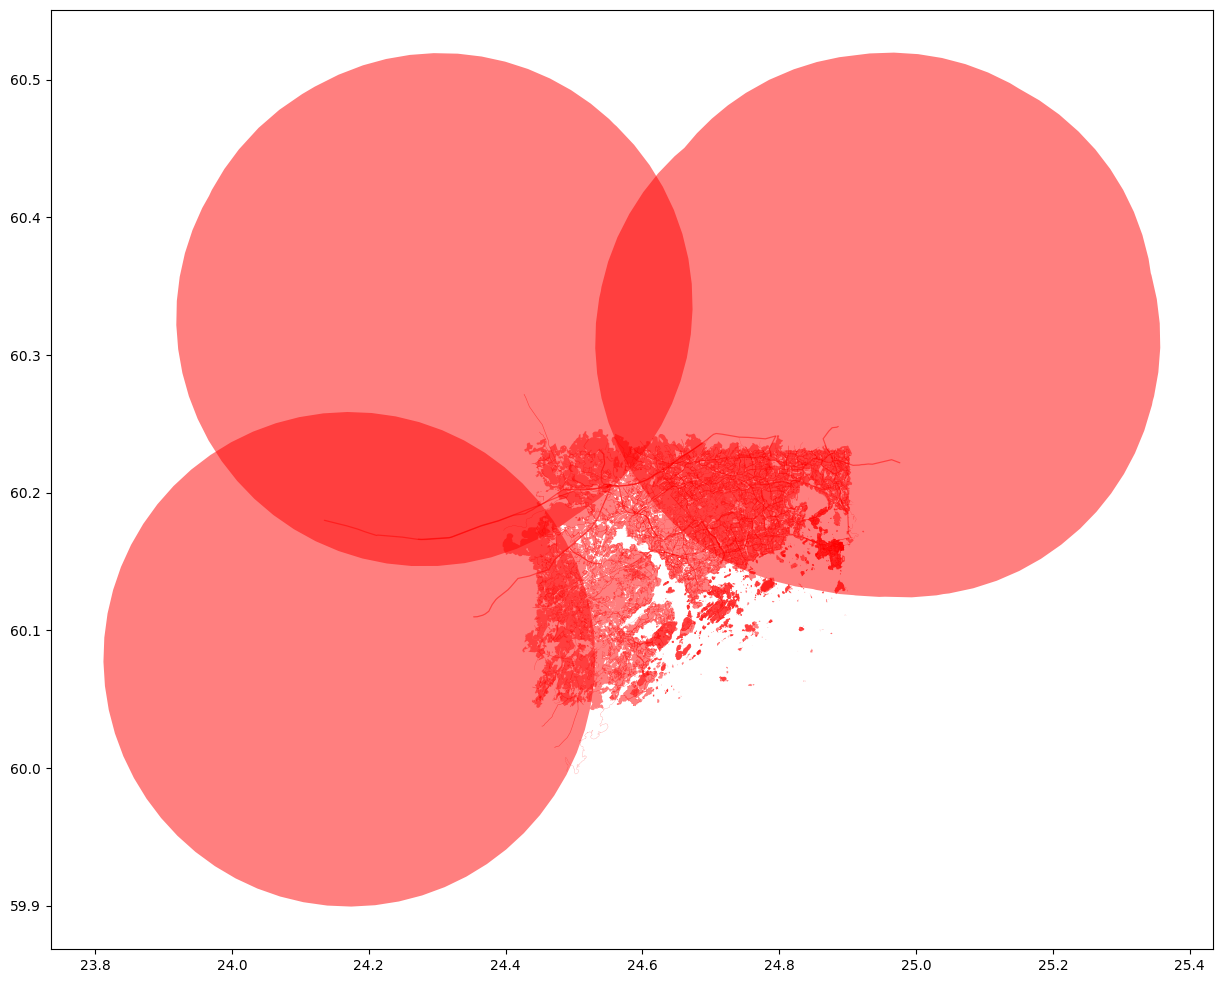

In [333]:
# %%script false --no-raise-error

# plot the buffered geometry
fig, ax = plt.subplots(figsize=(15, 15))
gdf_buffered.plot(ax=ax, color="red", alpha=0.5)

In [334]:
possible_launch_area = gpd.GeoSeries(possible_launch_area_from_difference, crs=main_crs)

In [335]:
minimum_polygon_area_meters = 100

print(f"before explode: {len(possible_launch_area)}")
exploded_possible_launch_area = possible_launch_area.explode(ignore_index=True)
print(f"after explode: {len(exploded_possible_launch_area)}")
possible_launch_area_metric = exploded_possible_launch_area.to_crs(metric_crs)
possible_launch_area = exploded_possible_launch_area[
    possible_launch_area_metric.area >= minimum_polygon_area_meters
]
print(f"after filtering: {len(possible_launch_area)}")
print(
    f"minimum area after filtering: {possible_launch_area.to_crs(metric_crs).area.min()}"
)

before explode: 1
after explode: 1520
after filtering: 993
minimum area after filtering: 100.40425901916828


### Plot

In [336]:
%%script false --no-raise-error

import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt


# Calculate pixel size of main ax
def attach_background(axes, detail_level, supersampling=2, interpolation="spline36"):
    bbox = axes.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    width_inches, height_inches = bbox.width, bbox.height
    width_px, height_px = width_inches * fig.dpi, height_inches * fig.dpi

    regrid_shape = (int(width_px * supersampling), int(height_px * supersampling))

    request = cimgt.GoogleTiles()
    axes.add_image(
        request,
        detail_level,
        interpolation=interpolation,
        interpolation_stage="rgba",
        regrid_shape=regrid_shape,
    )


def plot_data(axes, data_transform, detail_level, data, title):
    # axes.setxlim(bbox_xy[0], bbox_xy[2])
    # axes.setylim(bbox_xy[1], bbox_xy[3])
    axes.set_extent(bbox_xx_yy, crs=data_transform)
    attach_background(axes, detail_level)
    axes.gridlines(draw_labels=True, crs=data_transform)
    data.plot(
        ax=axes,
        markersize=markersize,
        linewidth=line_width,
        transform=data_transform,
    )
    axes.set_title(title)


markersize = 1
line_width = 0.5
detail_level = 4
figsize = (30, 50)
projection = ccrs.PlateCarree()
data_transform = ccrs.PlateCarree()

# Rewrite function calls to tuples without figure
plots = [
    (gdf, "Original data"),
    (gdf_buffered, "Buffered data"),
    (possible_launch_area, "Possible launch area"),
]

# fig = plt.figure(figsize=(30, 30))
fig, geo_axes = plt.subplots(
    len(plots), 1, figsize=figsize, subplot_kw=dict(projection=projection)
)
geo_axes = geo_axes.flatten()

for i, plot_tuple in enumerate(plots):
    print(f"Plotting {plot_tuple[1]}")
    axes = geo_axes[i]
    plot_data(axes, data_transform, detail_level, *plot_tuple)

# plt.close('all')

In [337]:
%%script false --no-raise-error

# Plot all land polygons
fig, ax = plt.subplots(figsize=(15, 15))
all_land_polygons.plot(ax=ax, color="red", alpha=0.5)

In [338]:
land_geofeather_filepath = Path("../data") / "land-polygons-split-3857" / "land_polygons.feather"
land_geofeather_filepath = land_geofeather_filepath.resolve()

land_polygons_from_coastline_loaded = geofeather.from_geofeather(
    land_geofeather_filepath
)

In [339]:
start = time.time()

land_polygons_from_coastline_crs = land_polygons_from_coastline_loaded.crs
print(f"crs of land_polygons_from_coastline: {land_polygons_from_coastline_crs}")

project_source_to_coastline = pyproj.Transformer.from_proj(
    main_crs,
    land_polygons_from_coastline_crs,
)

bbox_of_view_polygon = Polygon.from_bounds(*bbox_of_view_bounds)
transformed_bbox_polygon = transform(
    project_source_to_coastline.transform, bbox_of_view_polygon
)

# Print bounds
print("bbox_of_view_polygon bounds:", bbox_of_view_polygon.bounds)
print("transformed_bbox_polygon bounds:", transformed_bbox_polygon.bounds)
print(
    f"land_polygons_from_coastline bounds: {land_polygons_from_coastline_loaded.total_bounds}"
)

land_polygons_from_coastline = land_polygons_from_coastline_loaded.intersection(
    transformed_bbox_polygon
)
print("Found land polygons intersecting bbox", time.time() - start)
print(f"number of land_polygons_from_coastline: {len(land_polygons_from_coastline)}")
print(
    f"land_polygons_from_coastline bounds: {land_polygons_from_coastline.total_bounds}"
)

land_polygons_from_coastline = land_polygons_from_coastline.copy().to_crs(main_crs)
print(f"Reprojected land polygons to {main_crs}", time.time() - start)

# Do union of all land polygons
land_polygons_from_coastline_union = land_polygons_from_coastline.unary_union
land_from_coastline = gpd.GeoSeries(land_polygons_from_coastline_union, crs=main_crs)
print("Unioned land polygons", time.time() - start)

possible_launch_area_on_land = possible_launch_area.intersection(
    land_polygons_from_coastline_union
).explode(index_parts=False)
print("Found possible launch area on land", time.time() - start)

crs of land_polygons_from_coastline: PROJCRS["WGS 84 / Pseudo-Mercator",BASEGEOGCRS["WGS 84",ENSEMBLE["World Geodetic System 1984 ensemble",MEMBER["World Geodetic System 1984 (Transit)"],MEMBER["World Geodetic System 1984 (G730)"],MEMBER["World Geodetic System 1984 (G873)"],MEMBER["World Geodetic System 1984 (G1150)"],MEMBER["World Geodetic System 1984 (G1674)"],MEMBER["World Geodetic System 1984 (G1762)"],MEMBER["World Geodetic System 1984 (G2139)"],ELLIPSOID["WGS 84",6378137,298.257223563,LENGTHUNIT["metre",1]],ENSEMBLEACCURACY[2.0]],PRIMEM["Greenwich",0,ANGLEUNIT["degree",0.0174532925199433]],ID["EPSG",4326]],CONVERSION["Popular Visualisation Pseudo-Mercator",METHOD["Popular Visualisation Pseudo Mercator",ID["EPSG",1024]],PARAMETER["Latitude of natural origin",0,ANGLEUNIT["degree",0.0174532925199433],ID["EPSG",8801]],PARAMETER["Longitude of natural origin",0,ANGLEUNIT["degree",0.0174532925199433],ID["EPSG",8802]],PARAMETER["False easting",0,LENGTHUNIT["metre",1],ID["EPSG",8806]],PAR

<Axes: >

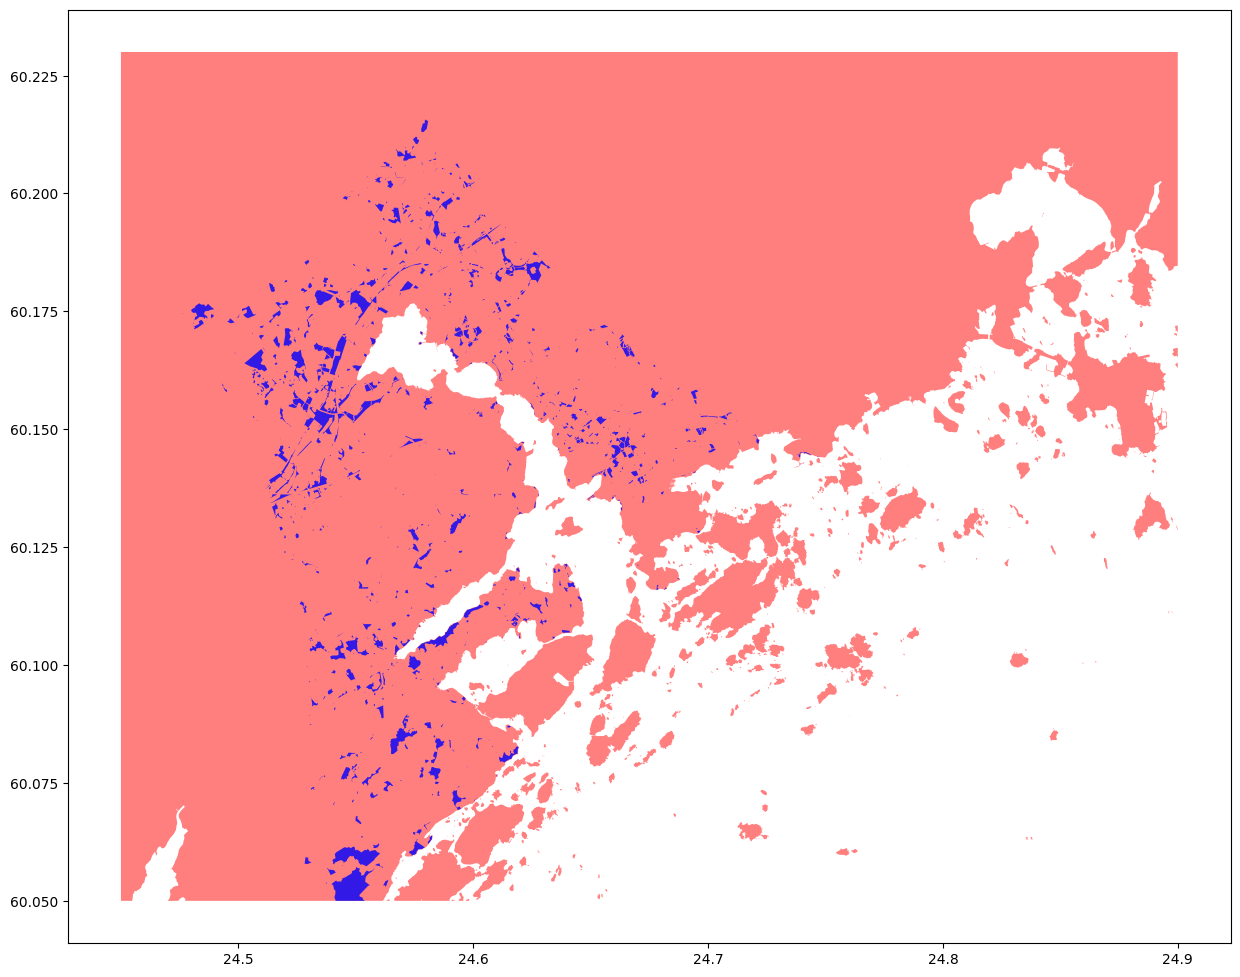

In [340]:
# Plot possible launch area on land on top of base map

fig, ax = plt.subplots(figsize=(15, 15))
land_polygons_from_coastline.plot(ax=ax, color="red", alpha=0.5)
possible_launch_area_on_land.plot(ax=ax, color="blue", alpha=0.8)


### Test whether points are good for launching (sanity check)

In [341]:
is_nice_area_for_launch_testset = [
    (Point(60.217595, 24.600559), False),
    (Point(60.189062, 24.8200870), False),
    (Point(60.152483, 24.719278), False),
    (Point(60.154029, 24.775810), False),
    (Point(60.18337, 24.62384), True),
    (Point(60.18337, 24.62384), True),
]

is_nice_area_for_launch_testset = [
    (Point(p.y, p.x), is_land_expected)
    for p, is_land_expected in is_nice_area_for_launch_testset
]

land_checking_gdf = possible_launch_area_on_land.copy().to_crs(main_crs)
for point, is_land_expected in is_nice_area_for_launch_testset:
    is_land_estimated = land_checking_gdf.contains(point).any()
    correct_estimation = is_land_estimated == is_land_expected
    # Using emoji to make it easier to spot
    print(
        f"{point} is nice place to launch: {is_land_estimated} {'✅' if correct_estimation else '❌'}"
    )

POINT (24.600559 60.217595) is nice place to launch: False ✅
POINT (24.820087 60.189062) is nice place to launch: False ✅
POINT (24.719278 60.152483) is nice place to launch: False ✅
POINT (24.77581 60.154029) is nice place to launch: False ✅
POINT (24.62384 60.18337) is nice place to launch: True ✅
POINT (24.62384 60.18337) is nice place to launch: True ✅


### Filter to the largest polygons

In [342]:
# Remove all but the largest polygons
top_n = 150
largest_polygons_launch_area: gpd.GeoSeries = possible_launch_area_on_land.to_crs(
    metric_crs
)
print(
    f"areas of largest polygons: {largest_polygons_launch_area.area.sort_values(ascending=False).head(top_n)}"
)
index_of_largest = list(
    largest_polygons_launch_area.area.sort_values(ascending=False).head(top_n).index
)
largest_polygons_shapely = sorted(largest_polygons_launch_area, key=lambda p: p.area)[-top_n:]

largest_polygons_gdf = gpd.GeoDataFrame(
    geometry=largest_polygons_shapely, crs=metric_crs
)

areas of largest polygons: 2       441163.431764
118     277094.434781
809     168222.802661
109     156079.277130
949     151696.400812
            ...      
1426      9693.349864
77        9629.941140
905       9628.485314
13        9615.399080
1399      9410.687071
Length: 150, dtype: float64


In [343]:
possible_launch_area_on_land_largest_polygons = largest_polygons_gdf.to_crs(main_crs)
possible_launch_area_on_land_largest_polygons

,geometry
0,"POLYGON ((24.59464 60.18776, 24.59414 60.18806..."
1,"POLYGON ((24.53674 60.18222, 24.53785 60.18199..."
2,"POLYGON ((24.57957 60.18376, 24.58018 60.18373..."
3,"POLYGON ((24.53805 60.09411, 24.53819 60.09448..."
4,"POLYGON ((24.49667 60.17347, 24.49800 60.17285..."
...,...
145,"POLYGON ((24.55111 60.17604, 24.55086 60.17657..."
146,"POLYGON ((24.56779 60.08550, 24.56746 60.08588..."
147,"POLYGON ((24.53865 60.15195, 24.53862 60.15195..."
148,"POLYGON ((24.54138 60.05900, 24.54107 60.05994..."


### Plot

<Axes: >

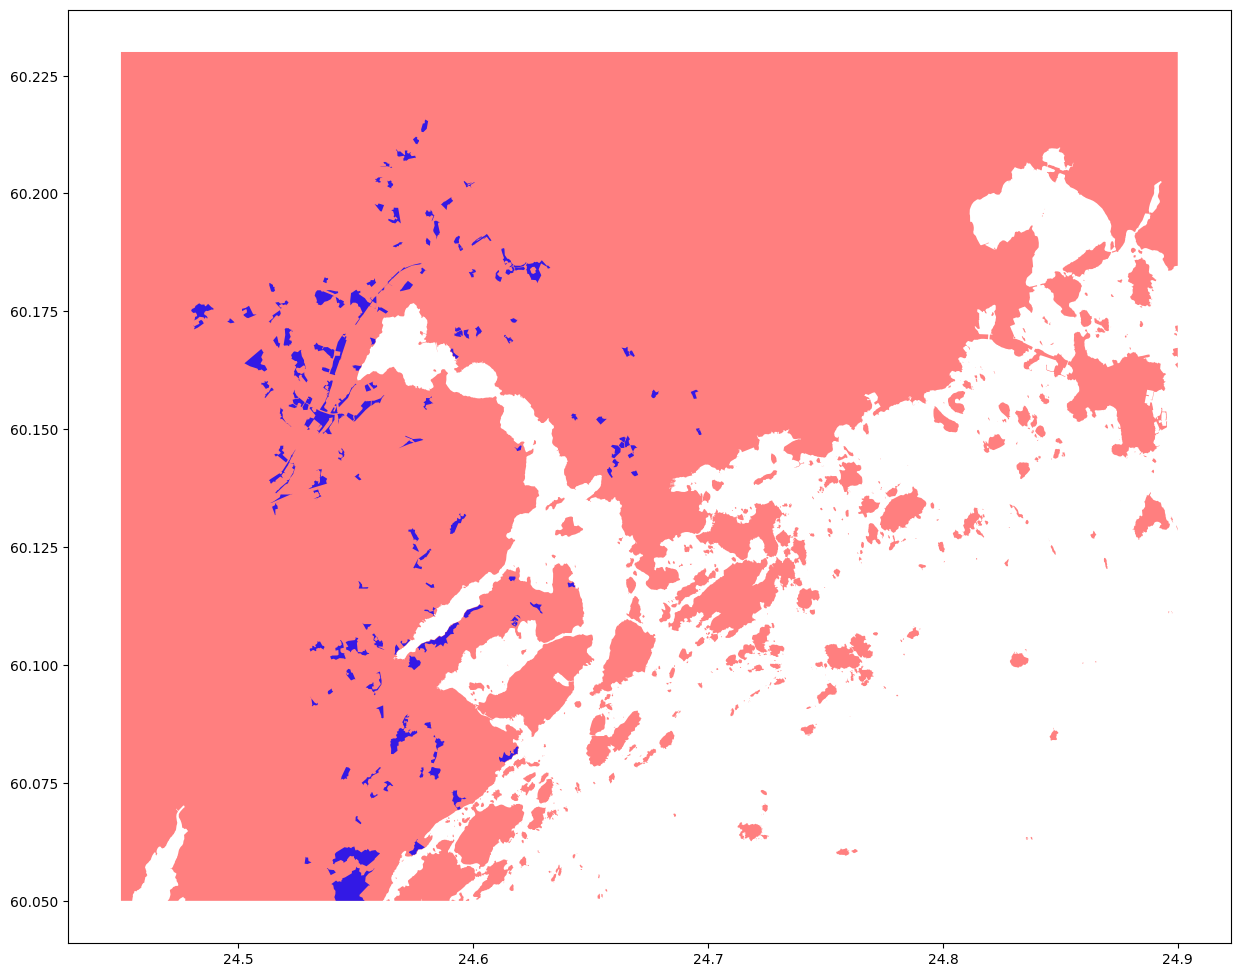

In [344]:
# plot
fig, ax = plt.subplots(figsize=(15, 15))
land_polygons_from_coastline.plot(ax=ax, color="red", alpha=0.5)
possible_launch_area_on_land_largest_polygons.plot(ax=ax, color="blue", alpha=0.8)

In [345]:
%%script false --no-raise-error

fig, ax = plt.subplots(figsize=(15, 15))
print("len(possible_launch_area_on_land_largest_polygons)", len(possible_launch_area_on_land_largest_polygons))
possible_launch_area_on_land_largest_polygons.to_crs(metric_crs).area.reset_index().drop(columns=['index']).cumsum().plot(ax=ax)
#.cumsum().plot(ax=ax)

In [346]:
all_polygons_at_point_query = """[out:json][timeout:25];
is_in({lat_lon});
out body;
>;
out skel qt;
"""

def point_on_OSM_polygon_not_within_bad_boundary(point_in_main_crs: Point) -> bool:
    boundary_tags = [
        ("amenity", "school"),
        ("barrier", "fence"),
        ("boundary", "administrative"),
        ("boundary", "historic"),
        ("boundary", "maritime"),
        ("boundary", "political"),
        ("boundary", "postal_code"),
        ("boundary", "public_transport"),
        ("boundary", "place"),
        ("boundary", "protected_area"),
        ("natural", "peninsula"),
        ("natural", "wetland"),
        ("landuse", "farmyard"),
        ("landuse", "brownfield"),
        ("landuse", "residential"),
        ("waterway", "boatyard"),
        ("leisure", "marina"),
        ("leisure", "pitch"),
        ("leisure", "sports_centre"),
        ("tourism", "hotel"),
    ]
    boundary_keys = [
        "airspace",
        "building",
        "was:building",
    ]
    #print(f"boundary_tags: {boundary_tags}")
    #print(f"boundary_keys: {boundary_keys}")
    print(point_in_main_crs)
    query = all_polygons_at_point_query.format(lat_lon=f"{point_in_main_crs.x},{point_in_main_crs.y}")
    #print(query)
    response = requests.post(overpass_url, data=query)
    #print(response.text)
    data = response.json()
    # pprint(data)
    elements_which_are_not_boundaries = []
    for element in data["elements"]:
        element_tags = element.get("tags")
        #print(f"element_tags: {pformat(element_tags)}")
        if element_tags is None:
            continue
        offending_tags = [
            tag
            for tag in element_tags.items()
            if tag in boundary_tags
        ]
        if offending_tags:
            # print(f"found offending tags: {pformat(offending_tags)}")
            continue
        offending_keys = [
            key
            for key in element_tags
            if key in boundary_keys
        ]
        if offending_keys:
            # print(f"found offending keys: {pformat(offending_keys)}")
            continue
        elements_which_are_not_boundaries.append(element)
    if elements_which_are_not_boundaries:
        print(f"elements_which_are_not_boundaries: {pformat([elem['tags'] for elem in elements_which_are_not_boundaries])}")
    return len(elements_which_are_not_boundaries) > 0
        

In [347]:
"""We'll have to check each polygon separately because polylabel doesn't support MultiPolygons.
Candidates are points, one per polygon at a time. The top candidate is the one which is
farthest away from the polygon's boundary. The top candidate is added to suggestions and the
circle is removed from the polygon. This is repeated until we have enough suggestions. Each
time a top candidate (new suggestion) is chosen, the polygon where the suggestion was found in
is added to polygons_to_check. The other polygons cannot contain a better candidate than the
ones we have already found, so they are not checked again.
"""

from copy import deepcopy
from dataclasses import dataclass


@dataclass(frozen=True)
class PointAndDistance:
    point: Point
    distance_from_poly: float


def candidate_point_to_main_crs_point(candidate_point: Point) -> Point:
    return Point(
        transform_main_to_metric.transform(*candidate_point.xy, direction=TransformDirection.INVERSE)
    )

def candidate_is_viable(candidate: PointAndDistance) -> bool:
    return point_on_OSM_polygon_not_within_bad_boundary(candidate_point_to_main_crs_point(candidate.point))

def remove_candidate(candidate: PointAndDistance) -> None:
    """Remove from candidate list, remove circle from polygon, add poly back to pool of polygons to check if it has not been seen too many times already"""
    circle_relation_to_distance_from_poly = 0.5
    poly = candidate_to_poly.pop(candidate)
    circle_to_remove_radius = min(size_of_removed_circle_meters, candidate.distance_from_poly * circle_relation_to_distance_from_poly)
    circle_to_remove = candidate.point.buffer(size_of_removed_circle_meters)
    orig_poly = deepcopy(poly)
    poly_check_count = polygon_check_counts[orig_poly]
    poly = poly.difference(circle_to_remove)
    if poly_check_count < max_times_check_polygon:
        del polygon_check_counts[orig_poly]
        polygon_check_counts[poly] = poly_check_count
        polygons_to_check.append(poly)
    else:
        pass

n_suggestions = 10
polylabel_tolerance = 5
size_of_removed_circle_meters = 50
reporting_interval = 1
max_times_check_polygon = 3

polygon_check_counts = defaultdict(int)
suggestions: list[Point] = []
# These were rejected because they were on areas which are not suitable for launching.
rejected_candidates: list[Point] = []
# Candidates are points, one per polygon at a time. They represent possible launch locations.
# A polygon is always either in candidate_to_poly or in polygons_to_check.
# A polygon is in polygons_to_check if a candidate has not been computed for it yet.
# A polygon is in candidate_to_poly if a candidate has been computed for it but it has not
# been selected as top candidate and added to suggestions yet.
polygons_to_check = list(possible_launch_area_on_land_largest_polygons.to_crs(metric_crs).explode().geometry)
candidate_to_poly: dict[PointAndDistance, Polygon] = {}
print(f"number of polygons_to_check: {len(polygons_to_check)}")
start = time.time()
while len(suggestions) < n_suggestions:
    while polygons_to_check:
        poly = polygons_to_check.pop()
        polygon_check_counts[poly] += 1
        candidate_point: Point = polylabel(poly, polylabel_tolerance)
        distance_to_boundary = poly.boundary.distance(candidate_point)
        candidate_with_distance = PointAndDistance(
            candidate_point, distance_to_boundary
        )
        candidate_to_poly[candidate_with_distance] = poly
    # The top candidate is the one which is farthest away from its polygon's boundary.
    top_candidate = None
    found_actual_top_candidate = False
    while not found_actual_top_candidate:
        possible_top_candidate = max(candidate_to_poly, key=lambda candidate: candidate.distance_from_poly)
        if candidate_is_viable(possible_top_candidate):
            top_candidate = possible_top_candidate
            actual_top_candidate_found = True
            break
        else:
            rejected_candidates.append(possible_top_candidate.point)
            remove_candidate(possible_top_candidate)
    if top_candidate is None:
        raise RuntimeError("No viable candidate found.")
    suggestions.append(top_candidate.point)
    remove_candidate(top_candidate)

    print(f"top candidate: {top_candidate}")

print(f"polygon check counts: {pformat(polygon_check_counts)}")

number of polygons_to_check: 150
POINT (60.05240938812671 24.54734170613372)
POINT (60.05915396152305 24.55437256179959)
POINT (60.15231066218632 24.53584780152601)
POINT (60.16430474824319 24.50712511519212)
POINT (60.17800342361822 24.53540566648389)
POINT (60.17538320582643 24.48365262033711)
POINT (60.17788205122596 24.54991549784826)
POINT (60.100248860671 24.57490093590066)
elements_which_are_not_boundaries: [{'landuse': 'meadow'}]
top candidate: PointAndDistance(point=<POINT (4.94e+05 6.66e+06)>, distance_from_poly=106.57974769904368)
POINT (60.05389012320828 24.55051859096419)
POINT (60.05977003592604 24.5446940246203)
POINT (60.17685989406704 24.55276448558059)
POINT (60.1654175160367 24.52482965995968)
POINT (60.08504609096521 24.56944395204561)
POINT (60.10425325667992 24.54860569094975)
POINT (60.10516048843143 24.58587065556874)
POINT (60.16803268882139 24.54380799679723)
elements_which_are_not_boundaries: [{'landuse': 'meadow'}]
top candidate: PointAndDistance(point=<POIN

In [348]:
# search for id "way/1120753173" in gdf
id_to_look_for = "relation/14989686"
gdf[gdf.apply(lambda row: id_to_look_for in row["ids"], axis=1)]

,,tags,ids,geometry,distance
15856,0,"{'natural': 'wood', 'type': 'multipolygon'}",[relation/14989686],"POLYGON ((24.57394 60.17959, 24.56963 60.17900...",25


In [349]:
polys_after_candidate_process = set(candidate_to_poly.values())
polys_after_candidate_process_gdf = gpd.GeoDataFrame(
    geometry=list(polys_after_candidate_process), crs=metric_crs
)
polys_after_candidate_process_gdf = polys_after_candidate_process_gdf.to_crs(main_crs)

<Axes: >

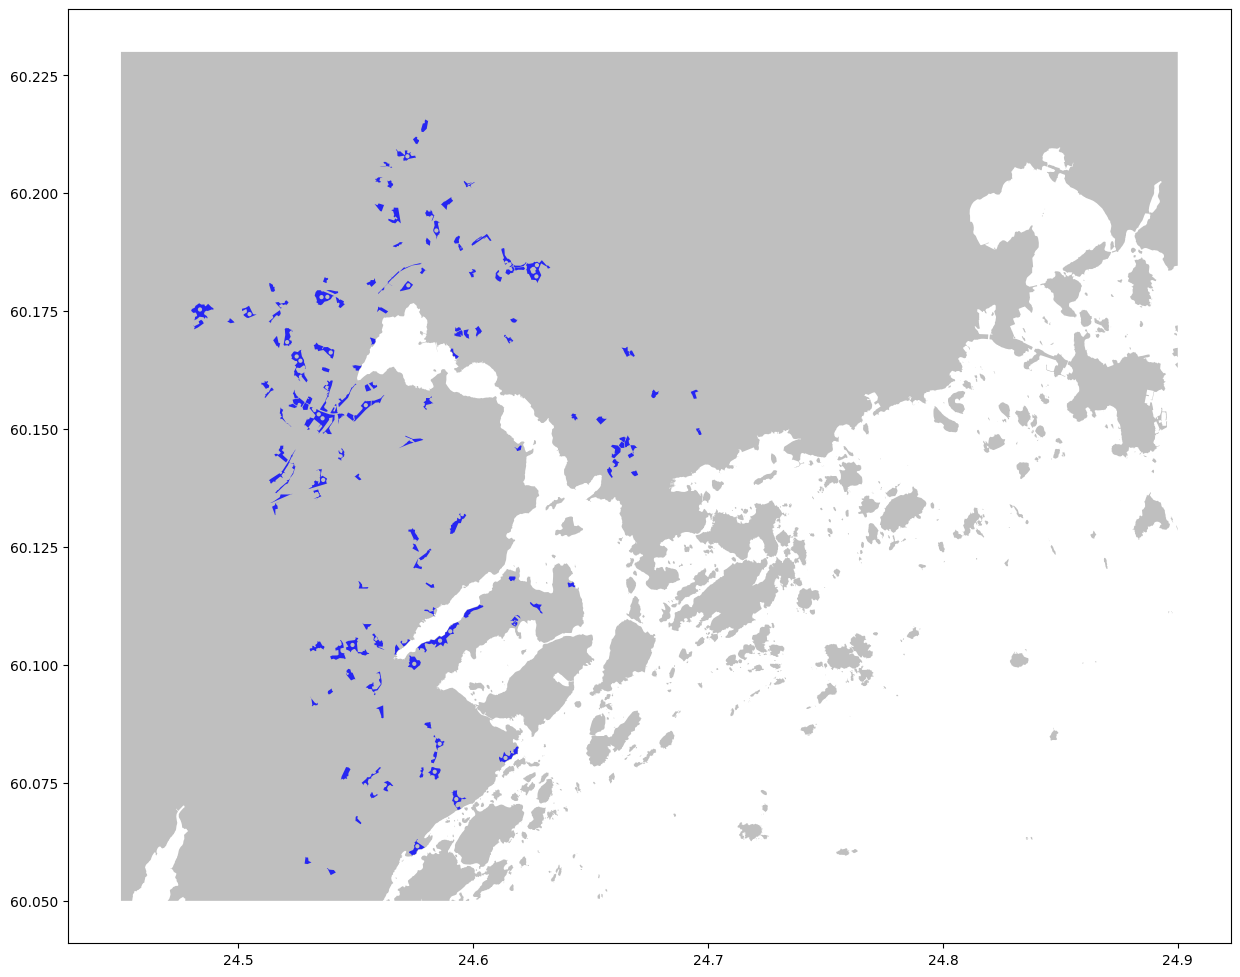

In [350]:
# %%script false --no-raise-error
# plot
fig, ax = plt.subplots(figsize=(15, 15))
# possible_launch_area_on_land_largest_polygons.plot(ax=ax, color="blue", alpha=0.8)
land_polygons_from_coastline.plot(ax=ax, color="grey", alpha=0.5)
polys_after_candidate_process_gdf.plot(ax=ax, color="blue", alpha=0.8)

In [351]:
suggestions_series = gpd.GeoSeries(suggestions, crs=metric_crs)
suggestions_gdf = suggestions_series.to_crs(main_crs)
len(suggestions_gdf)

10

In [352]:
rejected_candidates_series = gpd.GeoSeries(rejected_candidates, crs=metric_crs)
rejected_candidates_gdf = rejected_candidates_series.to_crs(main_crs)
len(rejected_candidates_gdf)

34

<Axes: >

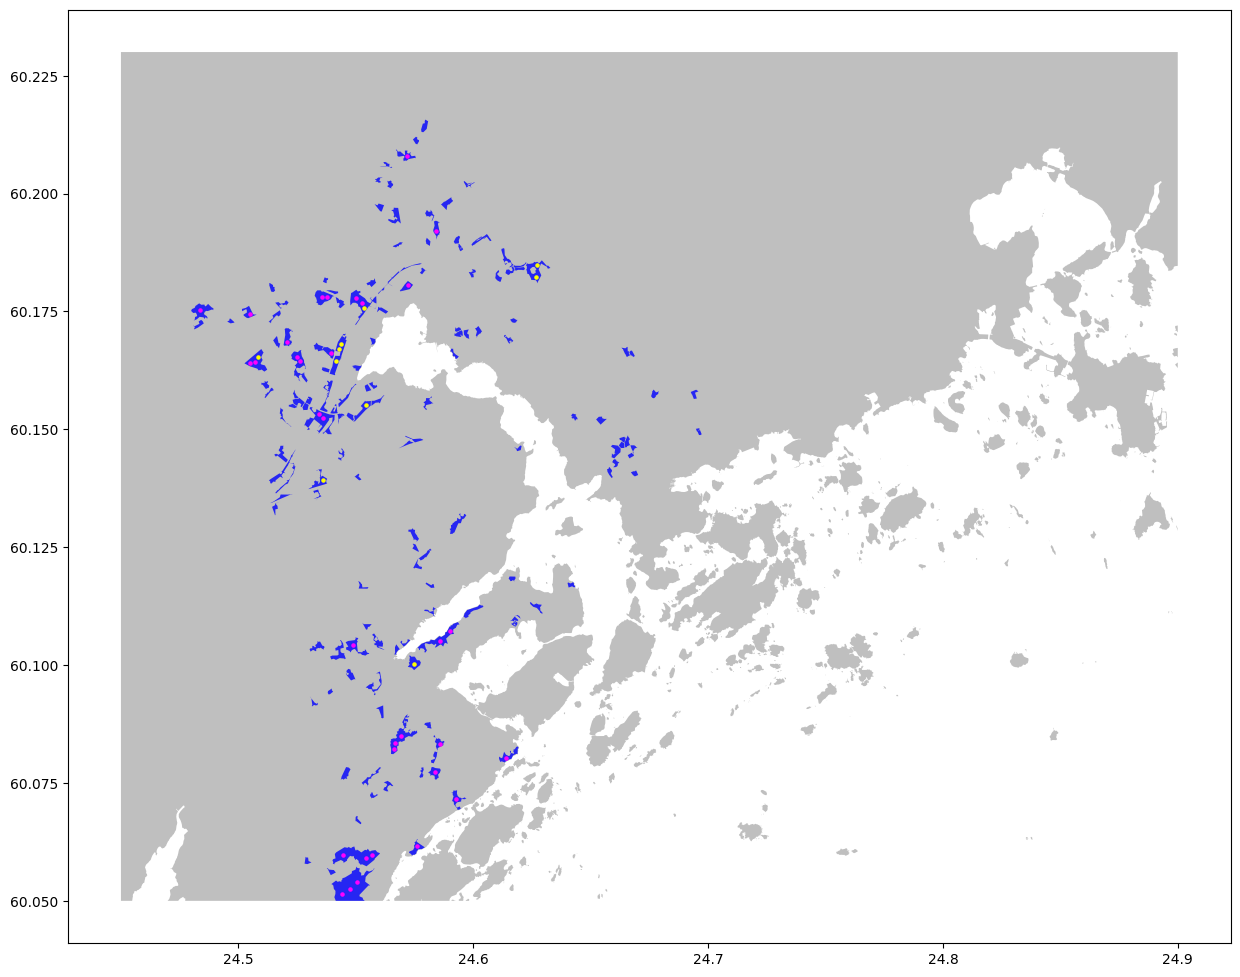

In [353]:
# plot
fig, ax = plt.subplots(figsize=(15, 15))
land_polygons_from_coastline.plot(ax=ax, color="grey", alpha=0.5)
possible_launch_area_on_land_largest_polygons.plot(ax=ax, color="blue", alpha=0.8)
suggestions_gdf.plot(ax=ax, color="yellow", markersize=5)
rejected_candidates_gdf.plot(ax=ax, color="magenta", markersize=5)

In [354]:
# print Google Maps URLs for the suggestions
def print_google_maps_url(point: Point):
    print(f"https://www.google.com/maps/search/?api=1&query={point.y},{point.x}")


for suggestion in suggestions_gdf:
    print_google_maps_url(suggestion)

https://www.google.com/maps/search/?api=1&query=60.100248860671,24.57490093590066
https://www.google.com/maps/search/?api=1&query=60.16803268882139,24.543807996797234
https://www.google.com/maps/search/?api=1&query=60.18238906644683,24.62690244405881
https://www.google.com/maps/search/?api=1&query=60.1653908669776,24.508245448759588
https://www.google.com/maps/search/?api=1&query=60.155096654925075,24.554264873945552
https://www.google.com/maps/search/?api=1&query=60.17579215784702,24.553512531844436
https://www.google.com/maps/search/?api=1&query=60.139246344013635,24.536126353434558
https://www.google.com/maps/search/?api=1&query=60.18478672053576,24.627128179814356
https://www.google.com/maps/search/?api=1&query=60.16447578812179,24.54171072445464
https://www.google.com/maps/search/?api=1&query=60.167093259551635,24.542841538972784


In [355]:
# print OSM URLs for the suggestions
def print_osm_url(point: Point):
    print(f"https://www.openstreetmap.org/search?query={point.y},{point.x}")


for suggestion in suggestions_gdf:
    print_osm_url(suggestion)

https://www.openstreetmap.org/search?query=60.100248860671,24.57490093590066
https://www.openstreetmap.org/search?query=60.16803268882139,24.543807996797234
https://www.openstreetmap.org/search?query=60.18238906644683,24.62690244405881
https://www.openstreetmap.org/search?query=60.1653908669776,24.508245448759588
https://www.openstreetmap.org/search?query=60.155096654925075,24.554264873945552
https://www.openstreetmap.org/search?query=60.17579215784702,24.553512531844436
https://www.openstreetmap.org/search?query=60.139246344013635,24.536126353434558
https://www.openstreetmap.org/search?query=60.18478672053576,24.627128179814356
https://www.openstreetmap.org/search?query=60.16447578812179,24.54171072445464
https://www.openstreetmap.org/search?query=60.167093259551635,24.542841538972784
